# RIEML DCC MODEL GRU to 405 Gridsearch to find optimum model
> Created Aug. 2025 <br>
> Nikhil Bisht<br>

First pass sequence to GRU and then output of the sequence to 405 to predict output

# Definitions

In [1]:
# standard system modules
import os, sys
import h5py 
import argparse
# standard module for tabular data
import pandas as pd
import json

# standard module for array manipulation
import numpy as np
from itertools import permutations

# standard statistical module
import scipy.stats as st
from scipy import linalg
from scipy.stats import ks_2samp
import skimage as ski

# standard module for high-quality plots
from PIL import Image
import matplotlib as mp
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
mp.rcParams.update(mp.rcParamsDefault)
%matplotlib inline

# to plot pixelized images
import imageio.v3 as im

# standard research-level machine learning toolkit from Meta (FKA: FaceBook)
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import tables
import torchvision
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image

from tqdm import tqdm
import random
import time
import plot
import datetime

# set a seed to ensure reproducibility
seed = 128
rnd  = np.random.RandomState(seed)

DATAFILE  = '/data/cb1/nbisht/anvil_scratch/projects/rieml/tubes_take8_time.h5'
MODELFILE = 'nnmodel.dict'

TEST_PERCENTAGE = 0.2

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print(f'Available device: {str(DEVICE):4s}')

idd = 989
what = "909 then 405 dilation 9 with gridsearch"
testnum=idd

Available device: cpu 


# Functions

In [2]:
def init_weights_constant(m):
    if isinstance(m, nn.Linear):
        #nn.init.constant_(m.weight, 0.5)
        nn.init.constant_(m.bias, 0.1)

def thisnet(layers, kernels, hidden_dims, bias, output_type):
    input_sequence_time_length = 2
    num_layers_GRU = layers
    kernels_GRU = kernels
    hidden_dims_GRU = hidden_dims
    hidden_dims_dcc = 256,
    conv_channels_dcc = 32
    model = hybridNET(in_seq=input_sequence_time_length, num_layers=num_layers_GRU, kernels = kernels_GRU, hidden_dims = hidden_dims_GRU, 
                      bias = bias, output_type = output_type, hidden_dims_dcc = hidden_dims_dcc, conv_channels_dcc = conv_channels_dcc)
    return model

def train(model,data,parameters, validatedata, validateparams, modellevel=1, model_name='model', epochs = 60000):
    lr = 1e-3
    batch_size=3
    w_d = 0.01
    mean_ve, std_ve, min_ve, max_ve = trainer(model,data,parameters,validatedata,validateparams,epochs=epochs,lr=lr,batch_size=batch_size, weight_decay = w_d, modellevel=modellevel, model_name=model_name)
    return mean_ve, std_ve, min_ve, max_ve


def trainer(model, x_train ,y_train, x_validate, y_validate, epochs=1, lr=1e-3, batch_size=10, test_num=0, weight_decay=0.01, modellevel=1, model_name='model'):
    optimizer = optim.AdamW( model.parameters(), lr=lr,weight_decay =weight_decay )
    from torch.optim.lr_scheduler import CyclicLR
    scheduler = CyclicLR(
            optimizer,
            base_lr=1e-7,
            max_lr=1e-3,
            step_size_up=30000,
            mode='triangular',   # or 'triangular2', 'exp_range'
            cycle_momentum=False # if you use Adam, turn this off
    )
    losses=[]
    a = torch.arange(x_train.shape[0])
    seed = 8675309
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    t0 = time.time()
    minlist=[];meanlist=[];maxlist=[];stdlist=[]
    for epoch in range(epochs):
        subset = torch.tensor(random.sample(list(a),batch_size))
        x_subset =  x_train[subset]
        y_subset = y_train[subset]
        optimizer.zero_grad()
        output1=model(x_subset)
        loss = model.criterion(output1, y_subset)
        loss.backward()
        optimizer.step()
        scheduler.step()
        tnow = time.time()
        tel = tnow-t0
        if (epoch>0 and epoch%100==0) or epoch==10:
            model.eval()
            validate_losses = plot.compute_losses_gru(model, x_validate, y_validate)
            model.train()

            time_per_epoch = tel/epoch
            epoch_remaining = epochs-epoch
            time_remaining_s = time_per_epoch*epoch_remaining
            eta = tnow+time_remaining_s
            etab = datetime.datetime.fromtimestamp(eta)

            if 1:
                hrs = time_remaining_s//3600
                minute = (time_remaining_s-hrs*3600)//60
                sec = (time_remaining_s - hrs*3600-minute*60)#//60
                time_remaining="%02d:%02d:%02d"%(hrs,minute,sec)
            if 1:
                eta = "%0.2d:%0.2d:%0.2d"%(etab.hour, etab.minute, int(etab.second))

            mean = validate_losses.mean()
            std = validate_losses.std()
            mmin = validate_losses.min()
            mmax = validate_losses.max()
            minlist.append(mmin)
            maxlist.append(mmax)
            meanlist.append(mean)
            stdlist.append(std)
            if epoch == 10:
                print("test %s %d L %0.2e LR %0.2e left %8s  eta %8s loss mean %0.2e var %0.2e min %0.2e max %0.2e"%
                    (model_name,epoch,loss, optimizer.param_groups[0]['lr'],time_remaining, eta, mean, std, mmin, mmax))
    print("Run time", tel)
    plt.clf()
    plt.plot(meanlist,c='k')
    plt.plot(np.array(meanlist)+np.array(stdlist),c='b')
    plt.plot(np.array(meanlist)-np.array(stdlist),c='b')
    plt.plot(minlist,c='r')
    plt.plot(maxlist,c='r')
    plt.yscale('log')
    plt.savefig('./gridsearch_plots/level'+str(modellevel)+'_models/errortime_test_'+model_name+'.png')
    return min(meanlist[-1000:]), min(stdlist[-1000:]), min(minlist[-1000:]), min(maxlist[-1000:])


class hybridNET(nn.Module):
    def __init__(self, in_seq = 2, out_seq = 1, arr_length=1000, phys_params = 3, num_layers = 1, kernels = [3], hidden_dims = [16], bias = True, output_type = 'reduced', return_all_layers = False, hidden_dims_dcc = 256, conv_channels_dcc = 32):
        """
        Initialize the hybridNET model
        :param in_seq: int
            Number of input sequences, how many time states given
        :param out_seq: int
            Number of output sequences, how many time states to predict
        :param arr_length: int
            length of the 1D array for a physical parameter
        :param phys_params: int
            Number of physical parameters inputted, 3 = Density, Pressure, Velocity_x
        :param num_layers: int
            number of layers in GRU
        :param kernels: (int,int,...)
            kernel size for each layer
        :param hidden_dims: (int,int,...)
            channel size for each layer
        :param hidden_dims_dcc: (int,int,...)
            channel size for each layer of 405 network
        :param conv_channels_dcc: (nt
            channel size for hidden layer of 405 net
        """
        super().__init__()
        self.in_seq = in_seq
        self.out_seq = out_seq
        self.arr_length = arr_length
        self.phys_params = phys_params
        self.num_layers = num_layers
        self.kernels = kernels
        self.hidden_dims = hidden_dims
        self.bias = bias
        self.output_type = output_type
        self.return_all_layers = return_all_layers
        self.hidden_dims_dcc = hidden_dims_dcc
        self.conv_channels_dcc = conv_channels_dcc

        self.ConvGRUNet = ConvGRUNet(in_seq = self.in_seq, out_seq = self.out_seq, arr_length=self.arr_length, phys_params = self.phys_params, num_layers = self.num_layers, kernels = self.kernels, 
                                     hidden_dims = self.hidden_dims, bias = self.bias, output_type = self.output_type, return_all_layers = self.return_all_layers)
        self.dccNET = DCC_NNet(output_length=self.arr_length, hidden_dims=self.hidden_dims_dcc, conv_channels=self.conv_channels_dcc, characteristic=False)
        self.l1 = nn.L1Loss()

    def criterion(self,guess,target, initial=None):
        L1 = self.l1(target,guess)
        return L1

    def forward(self, input_tensor):
        """
        :param input_tensor: (b, t_in, c, l)
        :param hidden_state:
        :return: output_tensor: (b, t_out, c, l)
        """
        GRU_output = self.ConvGRUNet(input_tensor)  #(b, t_out, c, l)
        dcc_output = self.dccNET(GRU_output[:,0,:,:]) #(b, c, l)
        return dcc_output[:,None,:,:]
        

class ConvGRUNet(nn.Module):
    def __init__(self, in_seq = 2, out_seq = 1, arr_length=1000, phys_params = 3, num_layers = 1, kernels = [3], hidden_dims = [16], bias = True, output_type = 'reduced', return_all_layers = False):
        """
        Initialize the ConvGRU model
        :param in_seq: int
            Number of input sequences, how many time states given
        :param out_seq: int
            Number of output sequences, how many time states to predict
        :param arr_length: int
            length of the 1D array for a physical parameter
        :param phys_params: int
            Number of physical parameters inputted, 3 = Density, Pressure, Velocity_x
        :param num_layers: int
            number of layers in GRU
        :param kernels: (int,int,...)
            kernel size for each layer
        :param hidden_dims: (int,int,...)
            channel size for each layer
        :param bias: bool
            Whether or not to add the bias.
        :param output_type: str
            Type of output, 'reduced' for reduced output, 'final' for last cell output
        :param return_all_layers: bool
            Whether to return all layers or just the last layer output
        """
        super().__init__()
        self.in_seq = in_seq
        self.out_seq = out_seq
        self.arr_length = arr_length
        self.phys_params = phys_params
        self.num_layers = num_layers
        self.kernels = kernels
        self.hidden_dims = hidden_dims
        self.bias = bias
        self.output_type = output_type
        self.return_all_layers = return_all_layers

        cell_list = []
        #check condition
        if not (len(self.kernels)==len(self.hidden_dims) and len(self.kernels)==num_layers):
            raise ValueError("kernel and hidden layer lists don't match number of layers!")
        
        for i in range(0, self.num_layers):
            cur_input_dim = self.phys_params if i == 0 else self.hidden_dims[i - 1]
            cell_list.append(ConvGRUCell(input_length=self.arr_length,
                                         phys_params=cur_input_dim,
                                         hidden_dim=self.hidden_dims[i],
                                         kernel_size=self.kernels[i],
                                         bias=self.bias))

        # convert python list to pytorch module
        self.cell_list = nn.ModuleList(cell_list)

        if self.output_type == 'reduced':
            self.out_linear = nn.Linear(self.in_seq,self.out_seq, bias = self.bias)

        self.out_cnn = nn.Conv1d(in_channels=self.hidden_dims[-1],
                                    out_channels=self.phys_params,
                                    kernel_size=self.kernels[-1],
                                    padding=self.kernels[-1]//2,
                                    bias=self.bias,
                                    padding_mode='reflect')

        self.mse=nn.MSELoss()
        self.log_derivative_weight = nn.Parameter(torch.tensor(0.0)) 
        self.hl = nn.HuberLoss(delta=0.2)
        self.l1 = nn.L1Loss()

    def criterion(self,guess,target, initial=None):
        L1 = self.l1(target,guess)
        return L1

    def forward(self, input_tensor, hidden_state=None):
        """
        :param input_tensor: (b, t_in, c, l)
        :param hidden_state:
        :return: output_tensor: (b, t_out, c, l)
        """
        hidden_state = self._init_hidden(batch_size=input_tensor.size(0))

        layer_output_list = []
        cur_layer_input = input_tensor
        for layer_idx in range(self.num_layers):
            h = hidden_state[layer_idx]
            output_inner = []
            for t in range(self.in_seq):
                # input current hidden and cell state then compute the next hidden and cell state through ConvGRU forward function
                h = self.cell_list[layer_idx](input_tensor=cur_layer_input[:, t, :, :], #(b,t,c,l)
                                              h_cur=h)
                output_inner.append(h)

            layer_output = torch.stack(output_inner, dim=1)
            cur_layer_input = layer_output

            layer_output_list.append(layer_output)
        
        last_layer_output = layer_output_list[-1] # shape (b,t_in,h,l)
        if self.output_type == 'final':
            out_arr = last_layer_output[:,-1,:,:] # shape (b,h,l)
            out_arr = self.out_cnn(out_arr)[:,None,:,:] # shape (b,t_out,c,l)
        elif self.output_type == 'reduced':
            last_layer_output = last_layer_output.permute(0,2,3,1) # shape (b,h,l,t_in)
            #Now linear over time domain
            last_layer_output = self.out_linear(last_layer_output) # shape (b,h,l,t_out)
            last_layer_output = last_layer_output.permute(0,3,1,2) # shape (b,t_out,h,l)
            #now iterate over output channels and convolve one last time
            out_arr = []
            for tout_idx in range(self.out_seq):
                out_arr.append(self.out_cnn(last_layer_output[:,tout_idx,:,:])) # shape (b,c,l) for a t
            
            out_arr = torch.stack(out_arr, dim=1)               # shape (b,t_out,c,l)
        else:
            raise ValueError("output_type must be 'reduced' or 'final'!")
        
        if self.return_all_layers:
            return layer_output_list, out_arr
        else:
            return out_arr

    def _init_hidden(self, batch_size):
        init_states = []
        for i in range(self.num_layers):
            init_states.append(self.cell_list[i].init_hidden(batch_size))
        return init_states


class ConvGRUCell(nn.Module):
    def __init__(self, input_length, phys_params, hidden_dim, kernel_size, bias):
        """
        Initialize a ConvGRU cell
        :param input_length: int
            length of the output 1D array for a physical parameter
        :param phys_params: int
            Number of physical parameters inputted, 3 = Density, Pressure, Velocity_x
        :param hidden_dim: int
            Number of channels of hidden state
        :param kernel_size: (int, int)
            Size of the convolutional kernel.
        :param bias: bool
            Whether or not to add the bias.
        """
        super(ConvGRUCell, self).__init__()
        self.length = input_length
        self.phys_params = phys_params
        self.padding = kernel_size // 2
        self.hidden_dim = hidden_dim
        self.bias = bias

        self.conv_gates = nn.Conv1d(in_channels=self.phys_params + self.hidden_dim,
                                    out_channels=2*self.hidden_dim,  # for update_gate,reset_gate respectively
                                    kernel_size=kernel_size,
                                    padding=self.padding,
                                    bias=self.bias,
                                    padding_mode='reflect')

        self.conv_can = nn.Conv1d(in_channels=self.phys_params + self.hidden_dim,
                              out_channels=self.hidden_dim, # for candidate neural memory
                              kernel_size=kernel_size,
                              padding=self.padding,
                              bias=self.bias,
                              padding_mode='reflect')

    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_dim, self.length)

    def forward(self, input_tensor, h_cur):
        """
        :param self:
        :param input_tensor: (b, c, l)
            input is actually the target_model
        :param h_cur: (b, c_hidden, l)
            current hidden state
        :return: h_next
            next hidden state
        """
        combined = torch.cat([input_tensor, h_cur], dim=1)
        combined_conv = self.conv_gates(combined)

        gamma, beta = torch.split(combined_conv, self.hidden_dim, dim=1)
        reset_gate = torch.sigmoid(gamma)
        update_gate = torch.sigmoid(beta)

        combined = torch.cat([input_tensor, reset_gate*h_cur], dim=1)
        cc_cnm = self.conv_can(combined)
        cnm = torch.tanh(cc_cnm)

        h_next = (1 - update_gate) * h_cur + update_gate * cnm
        return h_next


class DCC_NNet(nn.Module):
    def __init__(self, output_length=1000, hidden_dims=(128, 128), conv_channels=32, characteristic=False):
        super().__init__()
        self.output_length = output_length

        # Project 6 input values to a pseudo-spatial format (3 channels)
        #self.fc1 = nn.Linear(7, 3 * output_length)
        #self.relu1 = nn.ReLU()

        # Conv block 1 (acts on the "3 x output_length" format)
        dil = 1
        kern = 5
        padding = dil*(kern-1)//2
        dil2 = 2
        padding2 = dil2*(kern-1)//2
        dil3 = 4
        padding3 = dil3*(kern-1)//2
        dil4 = 8
        padding4 = dil4*(kern-1)//2
        self.conv1 = nn.Sequential(
            nn.Conv1d(3, conv_channels, kernel_size=kern, padding=padding, dilation=dil),
            nn.ReLU(),
            nn.Conv1d(conv_channels, 3, kernel_size=kern, padding=padding, dilation=dil),
            nn.ReLU()
        )

        # FC block 2: merge spatial info
        in_dim = 3*output_length
        out_dim = 3*output_length
        layers=[]
        dims = [in_dim] + list(hidden_dims) + [out_dim]
        for i in range(len(dims)-1):
            layers.append(nn.Linear(dims[i], dims[i+1]))
            if i < len(dims) - 2:
                layers.append(nn.ReLU())
        self.fc2 = nn.Sequential(*layers)

        # Conv block 2
        dil = 1
        kern = 3
        padding = dil*(kern-1)//2
        self.conv2 = nn.Sequential(
            nn.Conv1d(3, conv_channels, kernel_size=kern, padding=padding, dilation=dil),
            nn.ReLU(),
            nn.Conv1d(conv_channels, 3, kernel_size=kern, padding=padding, dilation=dil)
        )
        dil1 = 2
        kern1 = 3
        padding1 = dil1*(kern1-1)//2
        dil2 = 2
        kern2 = 3
        padding2 = dil2*(kern2-1)//2
        dil3 = 5
        kern3 = 7
        padding3 = dil3*(kern3-1)//2
        self.conv3a = nn.Sequential(
            nn.Conv1d(3, conv_channels, kernel_size=kern1, padding=padding1, dilation=dil1),
            nn.ReLU())
        self.conv3b = nn.Sequential(
            nn.Conv1d(conv_channels, 2*conv_channels, kernel_size=kern2, padding=padding2, dilation=dil2),
            nn.ReLU())
        self.conv3e = nn.Sequential(
            nn.Conv1d(2*conv_channels, conv_channels, kernel_size=kern2, padding=padding2, dilation=dil2),
            nn.ReLU())
        self.convdone = nn.Sequential(
            nn.Conv1d(conv_channels, 3, kernel_size=kern1, padding=padding1, dilation=dil1)
        )
        self.conv1.apply(init_weights_constant)
        self.conv2.apply(init_weights_constant)
        self.conv3a.apply(init_weights_constant)
        self.conv3b.apply(init_weights_constant)
        self.conv3e.apply(init_weights_constant)
        self.convdone.apply(init_weights_constant)
        self.fc2.apply(init_weights_constant)
        #self.fc1.apply(init_weights_constant)

        self.T = nn.Parameter(torch.eye(3) + 0.01 * torch.randn(3, 3)) 

        self.mse=nn.MSELoss()
        self.log_derivative_weight = nn.Parameter(torch.tensor(0.0)) 

        embed_dim=output_length
        num_heads = 4
        self.hl = nn.HuberLoss(delta=0.2)
        self.l1 = nn.L1Loss()



    def criterion(self,guess,target, initial=None):
        L1 = self.l1(target,guess)
        return L1

    def forward(self, x):
        batch_size=x.shape[0]
        # FC1 to expand global features into spatial representation
        #x = self.fc1(x)  # (batch_size, 3*output_length)
        #x = self.relu1(x)
        #x = x.view(batch_size, 3, self.output_length)  # shape (B, 3, L)

        # Conv block 1: local patterns
        x = x + self.conv1(x)  # Residual connection

        # FC2 block: reprocess globally
        x_flat = x.view(batch_size, -1)
        x_flat = self.fc2(x_flat)
        x = x_flat.view(batch_size,3, self.output_length)

        # Conv block 2: refine locally again
        x = x + self.conv2(x)
        x1 = self.conv3a(x)
        x2 = self.conv3b(x1)
        x5 =x1+ self.conv3e(x2)
        z = x+self.convdone(x5)
    

        return z  # shape (B, 3, output_length)



# Load Images

In [3]:
from importlib import reload
import plot
reload(plot)

import tube_loader

def get_data(in_seq = 2, dilation = 1, out_seq = 1, nvalid=50, ntest=100):
    '''
    in_seq: number of input time snapshots
    dilation: how many snapshots ahead to predict
    out_seq: number of output snapshots
    '''
    seq_l = in_seq+(dilation-1)+out_seq
    rieml_data, parameters= tube_loader.read_all_parameters(DATAFILE)
    reshaped_data = rieml_data.reshape(3000,11,3,1000)
    sequenced_data = np.array([]).reshape(0,3,3,1000)
    for i in range(11-seq_l+1):
        time_indices_in = [j for j in range(i,i+in_seq)]
        time_indices_out = [j for j in range(i+in_seq+dilation-1,i+in_seq+dilation-1+out_seq)]
        time_indices_in.extend(time_indices_out)
        time_indices = time_indices_in
        print(time_indices)
        sequenced_data = np.concatenate((sequenced_data,reshaped_data[:,time_indices,:,:]), axis=0)
    #shuffle dataset
    shuffled_indices = torch.randperm(sequenced_data.shape[0])
    sequenced_data_shuffled = torch.index_select(torch.from_numpy(sequenced_data), dim=0, index=shuffled_indices)
    len_seq = sequenced_data_shuffled.shape[0]
    ntrain = len_seq-nvalid-ntest
    # Split the tensor
    train_dataset, test_dataset, validation_dataset = torch.split(sequenced_data_shuffled.float(), [ntrain,ntest,nvalid], dim=0)
    X = {'train': train_dataset[:,0:2,:,:], 'test': test_dataset[:,0:2,:,:], 'validate': validation_dataset[:,0:2,:,:]}
    y = {'train': train_dataset[:,2,:,:][:, None, :, :], 'test': test_dataset[:,2,:,:][:, None, :, :], 'validate': validation_dataset[:,2,:,:][:, None, :, :]}
    return X,y

rieml_data_seq, parameters_seq = get_data(in_seq = 2, dilation = 9, out_seq = 1, nvalid=50, ntest=100)

[0, 1, 10]


# Find Best Model

In [4]:
def model_search_space_layer_one():
    """
    Define the search space for hyperparameter tuning for layer one. Bigger space to see what types of models work best.
    Returns:
        A dictionary containing the search space parameters.
    """
    search_space = {
        'bias': [True, False],
        'output_type': ['reduced', 'final'],
        #'layers': [1,2,3,4],
        'kernels': [3, 5, 7, 9],
        'hidden_dims': [8, 16, 32, 64, 128]
    }

    return search_space

def model_search_space():
    """
    Define the search space for hyperparameter tuning for higher layers. Smaller space to reduce computation time.
    Returns:
        A dictionary containing the search space parameters.
    """
    search_space = {
        'bias': [False],
        'output_type': ['final'],
        'kernels': [3, 5, 9],
        'hidden_dims': [32, 64]
    }

    return search_space

def all_models(layers):
    """
    Generate all combinations of hyperparameters for a given number of layers [1,2,3,4].
    Returns:
        A table containing a unique combination of hyperparameters as rows.
    """
    search_space = model_search_space()
    combinations = []
    import itertools
    all_kernels = list(itertools.product(search_space['kernels'], repeat=layers))
    all_hidden_dims = list(itertools.product(search_space['hidden_dims'], repeat=layers))
    i = 0
    for bi in range(len(search_space['bias'])):
        for ot in range(len(search_space['output_type'])):
            for ke in range(len(all_kernels)):
                for hi in range(len(all_hidden_dims)):
                    model_param = {
                        'model_name': 'model_'+str(i),
                        'layers': layers,
                        'bias': search_space['bias'][bi],
                        'output_type': search_space['output_type'][ot],
                        'kernels': list(all_kernels[ke]),
                        'hidden_dims': list(all_hidden_dims[hi])
                    }
                    combinations.append(model_param)
                    i += 1

    import pandas as pd
    df = pd.DataFrame(combinations)
    return df

Number of models in search space for 3 layers: 216
Current pruning level: 0, Minimum epoch: 0
Training model 1/216: model_0
test model_0 10 L 8.50e-01 LR 4.67e-07 left 00:00:39  eta 16:22:54 loss mean 6.38e-01 var 1.65e-01 min 3.31e-01 max 1.03e+00
Run time 29.503804922103882
Training model 2/216: model_1
test model_1 10 L 9.05e-01 LR 4.67e-07 left 00:00:33  eta 16:23:17 loss mean 6.85e-01 var 1.65e-01 min 3.90e-01 max 1.08e+00
Run time 31.099499464035034
Training model 3/216: model_2
test model_2 10 L 1.01e+00 LR 4.67e-07 left 00:00:36  eta 16:23:52 loss mean 7.90e-01 var 1.69e-01 min 4.75e-01 max 1.19e+00
Run time 32.19718289375305
Training model 4/216: model_3
test model_3 10 L 7.29e-01 LR 4.67e-07 left 00:00:36  eta 16:24:25 loss mean 5.26e-01 var 1.51e-01 min 2.86e-01 max 8.95e-01
Run time 34.702080726623535
Training model 5/216: model_4
test model_4 10 L 6.79e-01 LR 4.67e-07 left 00:00:33  eta 16:24:57 loss mean 5.16e-01 var 1.38e-01 min 2.77e-01 max 8.53e-01
Run time 30.86889815

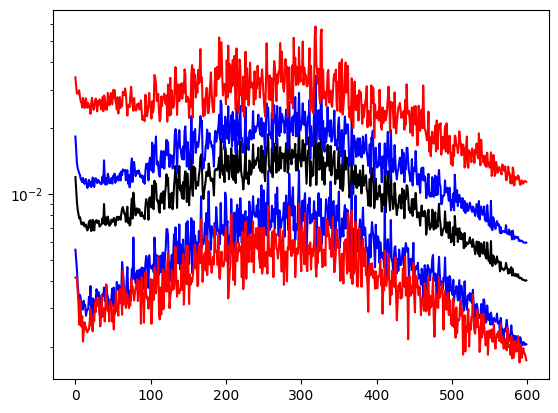

In [5]:
pruning_epochs = np.array([1000, 5000, 10000, 20000, 40000, 60000])  # Epochs at which pruning occurs
pruning_number = np.array([0.5, 0.5, 0.5, 0.5, 0.5])  # 50% for all levels

layers = 3

all_model_df = all_models(layers)
all_model_df.to_csv('gridsearch_plots/level'+str(layers)+'_model_search_space_unpruned.csv', index=False)
print(f"Number of models in search space for {layers} layers: {len(all_model_df)}")
model_dict = {}

stayin = True

min_epoch = 0
pruning_level = 0

while stayin:
    print(f"Current pruning level: {pruning_level}, Minimum epoch: {min_epoch}")
    for i in range(len(all_model_df)):
        print(f"Training model {i+1}/{len(all_model_df)}: {all_model_df.iloc[i]['model_name']}")
        model_params = all_model_df.iloc[i]
        if pruning_level == 0:
            model = thisnet(layers=model_params['layers'], kernels=model_params['kernels'], hidden_dims=model_params['hidden_dims'], bias=model_params['bias'], output_type=model_params['output_type'])
        else:
            model = model_dict[model_params['model_name']]
        nparam = sum(p.numel() for p in model.parameters() if p.requires_grad)
        all_model_df.loc[i, 'nparams'] = nparam

        t0 = time.time()

        mean_ve, std_ve, min_ve, max_ve = train(model,rieml_data_seq['train'],parameters_seq['train'], rieml_data_seq['validate'],parameters_seq['validate'],
                                                 modellevel=layers, model_name=model_params['model_name'], epochs = pruning_epochs[pruning_level])
    
        # Save model performance
        model_dict[model_params['model_name']] = model
        t1 = time.time() - t0
        hrs = t1//3600
        minute = (t1-hrs*3600)//60
        sec = (t1 - hrs*3600-minute*60)#//60
        total_time="%02d:%02d:%02d"%(hrs,minute,sec)
        all_model_df.loc[i, 'time'] = total_time
        all_model_df.loc[i, 'mean_ve'] = mean_ve
        all_model_df.loc[i, 'std_ve'] = std_ve
        all_model_df.loc[i, 'min_ve'] = min_ve
        all_model_df.loc[i, 'max_ve'] = max_ve

        #test losses
        loss_test = plot.compute_losses_gru(model, rieml_data_seq['test'],parameters_seq['test'])
        all_model_df.loc[i, 'mean_e_test'] = loss_test.mean()
        all_model_df.loc[i, 'std_e_test'] = loss_test.std()
        all_model_df.loc[i, 'min_e_test'] = loss_test.min()
        all_model_df.loc[i, 'max_e_test'] = loss_test.max()

    #get min epoch again
    min_epoch = pruning_epochs[pruning_level]
    if min_epoch < 60000:
        #Time to prune
        print(f"Pruning models at level {pruning_level} with threshold {pruning_epochs[pruning_level]} epochs")
        #get the top 50% of models based on mean_e_test
        threshold = pruning_number[pruning_level]
        threshold_value = all_model_df['mean_e_test'].quantile(threshold)
        print(f"Threshold value for pruning: {threshold_value}")
        #select the models that are above the threshold
        all_model_df = all_model_df[all_model_df['mean_e_test'] <= threshold_value]
        all_model_df = all_model_df.reset_index(drop=True)
        print(f"Number of models after pruning: {len(all_model_df)}")

        #remove those models from model_dict
        model_names_to_keep = set(all_model_df['model_name'])
        model_dict = {k: v for k, v in model_dict.items() if k in model_names_to_keep}
        pruning_level += 1
    if min_epoch==60000:
        stayin = False
    

#save file after all models are trained and tested
#sort by mean validation error
all_model_df = all_model_df.sort_values(by='mean_e_test', ascending=True)
all_model_df.to_csv('gridsearch_plots/level'+str(layers)+'_model_search_space.csv', index=False)

In [6]:
all_model_df

,model_name,layers,bias,output_type,kernels,hidden_dims,nparams,time,mean_ve,std_ve,min_ve,max_ve,mean_e_test,std_e_test,min_e_test,max_e_test
5,model_167,3,False,final,"[9, 3, 9]","[64, 64, 64]",1966284.0,00:51:38,0.003739,0.002240,0.001397,0.012462,0.003651,0.003489,0.001233,0.029016
4,model_137,3,False,final,"[5, 9, 9]","[32, 32, 64]",1793580.0,00:38:05,0.004402,0.004036,0.001635,0.023846,0.003791,0.004950,0.001252,0.046928
3,model_97,3,False,final,"[5, 5, 3]","[32, 32, 64]",1657260.0,00:25:22,0.003552,0.001998,0.001162,0.011301,0.003805,0.003952,0.001301,0.034784
1,model_59,3,False,final,"[3, 9, 5]","[32, 64, 64]",1853676.0,00:50:14,0.003990,0.001987,0.001641,0.010789,0.003863,0.003612,0.001756,0.028812
2,model_72,3,False,final,"[5, 3, 3]","[32, 32, 32]",1607820.0,00:23:10,0.003614,0.002115,0.001367,0.013243,0.003956,0.005761,0.001347,0.056881
6,model_172,3,False,final,"[9, 5, 3]","[64, 32, 32]",1734444.0,00:38:20,0.004001,0.001937,0.001691,0.010924,0.004237,0.004474,0.001954,0.041289
0,model_27,3,False,final,"[3, 5, 3]","[32, 64, 64]",1730412.0,00:48:00,0.004059,0.002109,0.001545,0.011239,0.004451,0.004548,0.001555,0.034735


# Retrain and save the best n models

In [7]:
def test_plot_gru(datalist, parameters,model, fname="plot", dirname="./plots"):
    nd=-1
    pred_all = model(datalist.float())
    for datum, param1 in zip(pred_all,parameters):
        rows = param1.shape[0]
        nd+=1
        fig,axes=plt.subplots(rows,3,figsize=(12,4))
        for t in range(rows):
            if rows>1:
                ax=axes[t]
            else:
                ax = axes
            fields = ['density_'+str(t),'pressure_'+str(t),'velocity_'+str(t)]
            ymax = [2,2,1.1]
            for nf,field in enumerate(fields):
                loss_t = model.criterion(datum[t][nf], param1[t][nf] ,initial=datum[0])
                ax[nf].plot( param1[t][nf], c='k')
                ymax[nf]=max([ymax[nf],param1[t][nf].max().item()])
                ax[nf].plot( param1[t][1][nf], c='k', linestyle='--')
                ymax[nf]=max([ymax[nf],param1[t][nf].max().item()])
                zzz = datum[t][nf].detach().numpy()
                if np.isnan(zzz).sum() > 0:
                    print("Is nan", np.isnan(zzz).sum(), nd, nf)
                ax[nf].set(title='error %0.2e'%loss_t)
                ax[nf].plot( zzz, c='r')
                ymax[nf]=max([ymax[nf],zzz.max().item()])
                ax[nf].set(ylabel=field)
            ax[0].set(ylim=[0,ymax[0]])
            ax[1].set(ylim=[0,ymax[1]])
            ax[2].set(ylim=[-1.1,ymax[2]])
        fig.tight_layout()
        oname="%s/rieML_%s_%04d"%(dirname,fname,nd)
        fig.savefig(oname)
        print(oname)
        plt.close(fig)
    return pred_all
def plot_hist(loss_train,loss_test,loss_validate,testnum, dirname="./plots"):
    everything = torch.cat([loss_train, loss_test,loss_validate])
    bmin = min([min(everything),1e-4])
    bmax = max([max(everything),1e-1])
    bins = np.geomspace(bmin,bmax,64)
    fig,ax=plt.subplots(1,1)
    for nl in [0,1,2]:
        lll = [loss_train, loss_test, loss_validate][nl]
        hist, bins, obj=ax.hist(lll.detach().numpy(), bins=bins, histtype='step', 
                                label= "mean %0.2e"%(lll.mean()))
        bc = 0.5*(bins[1:]+bins[:-1])
        #Lmax = bc[np.argmax(hist)]
    ax.legend(loc=0)
    ax.set_yscale('log')
    ax.set(xlabel='loss',xscale='log')
    fig.savefig('./%s/errhist_test%d'%(dirname,testnum))


Training model 1/7: model_167
test model_167 10 L 7.79e-01 LR 4.67e-07 left 02:46:39  eta 22:15:12 loss mean 5.56e-01 var 1.57e-01 min 2.93e-01 max 9.37e-01
Run time 8806.287702798843
model saved  models/bestmodel_0_model_167.pth
losses
plot
best_plots/level_3_models/plots_model_167/rieML_test989_test_best_0000
best_plots/level_3_models/plots_model_167/rieML_test989_test_best_0001
best_plots/level_3_models/plots_model_167/rieML_test989_test_best_0002
best_plots/level_3_models/plots_model_167/rieML_test989_test_best_0003
best_plots/level_3_models/plots_model_167/rieML_test989_test_best_0004
best_plots/level_3_models/plots_model_167/rieML_test989_test_worst_0000
best_plots/level_3_models/plots_model_167/rieML_test989_test_worst_0001
best_plots/level_3_models/plots_model_167/rieML_test989_test_worst_0002
best_plots/level_3_models/plots_model_167/rieML_test989_test_worst_0003
best_plots/level_3_models/plots_model_167/rieML_test989_test_worst_0004
best_plots/level_3_models/plots_model_167/r

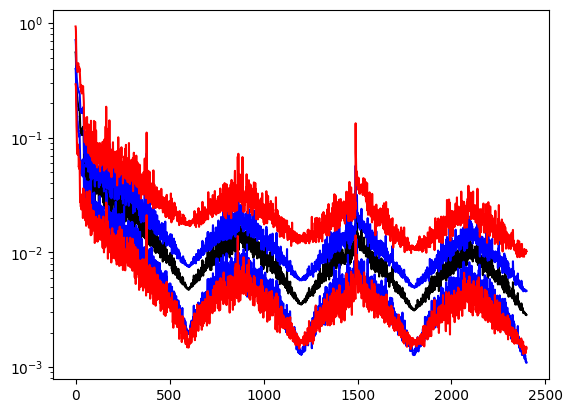

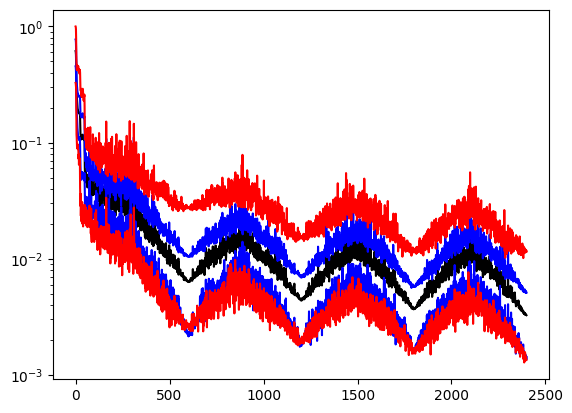

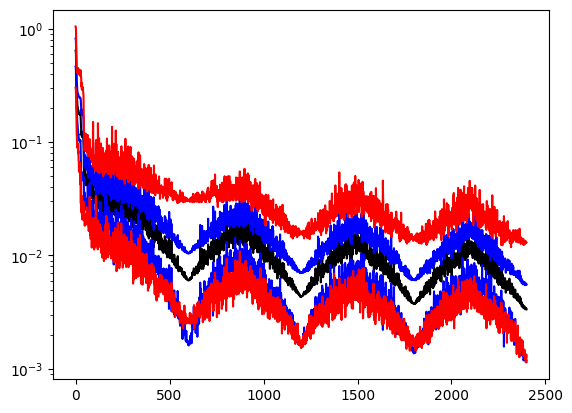

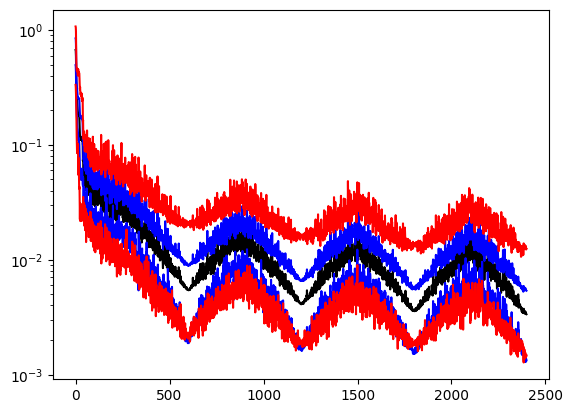

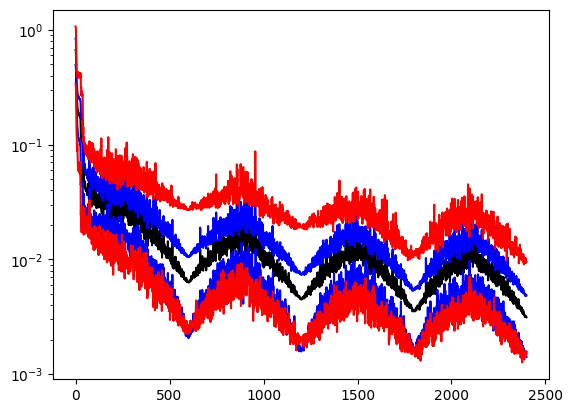

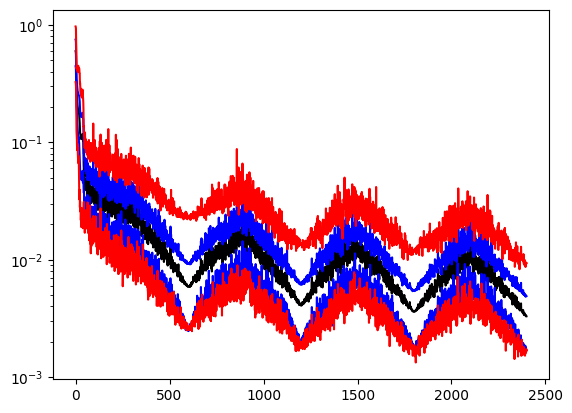

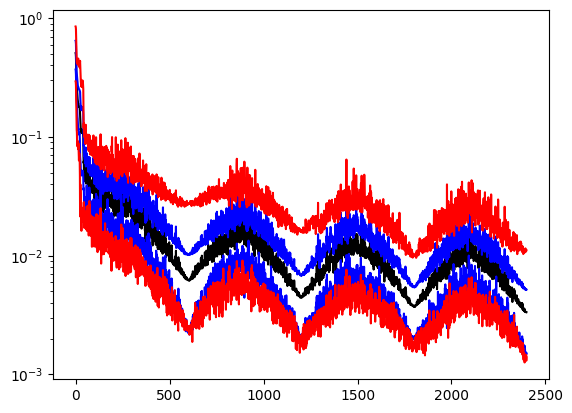

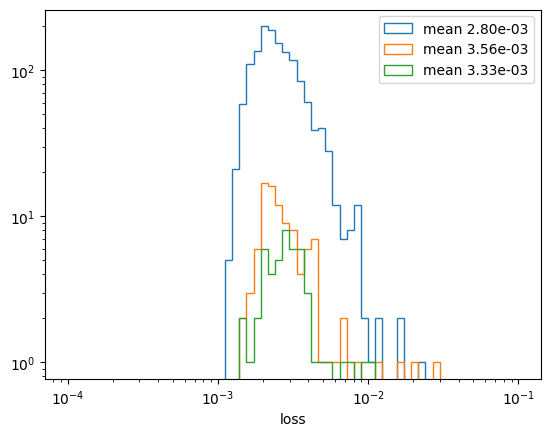

In [8]:
def make_dir(dir_path):
    if not os.path.exists(dir_path):
        os.makedirs(dir_path)

for i in range(len(all_model_df)):
    print(f"Training model {i+1}/{len(all_model_df)}: {all_model_df.iloc[i]['model_name']}")
    model_params = all_model_df.iloc[i]
    model_dir = "best_plots/level_3_models/plots_%s"%model_params['model_name']
    make_dir(model_dir)
    model = thisnet(layers=model_params['layers'], kernels=model_params['kernels'], hidden_dims=model_params['hidden_dims'], bias=model_params['bias'], output_type=model_params['output_type'])
    nparam = sum(p.numel() for p in model.parameters() if p.requires_grad)
    all_model_df.loc[i, 'nparams'] = nparam

    t0 = time.time()

    mean_ve, std_ve, min_ve, max_ve = train(model,rieml_data_seq['train'],parameters_seq['train'], rieml_data_seq['validate'],parameters_seq['validate'],
                                                modellevel=layers, model_name=model_params['model_name'], epochs = 240000)

    # Save model performance
    oname = "models/bestmodel_%d_%s.pth"%(i,model_params['model_name'])
    torch.save(model.state_dict(), oname)
    print("model saved ",oname)

    t1 = time.time() - t0
    hrs = t1//3600
    minute = (t1-hrs*3600)//60
    sec = (t1 - hrs*3600-minute*60)#//60
    total_time="%02d:%02d:%02d"%(hrs,minute,sec)
    print('losses')
    skip_train_plot = 2
    loss_train = torch.from_numpy(plot.compute_losses_gru(model, rieml_data_seq['train'][::skip_train_plot],parameters_seq['train'][::skip_train_plot]))
    loss_test = torch.from_numpy(plot.compute_losses_gru(model, rieml_data_seq['test'],parameters_seq['test']))
    loss_validate = torch.from_numpy(plot.compute_losses_gru(model, rieml_data_seq['validate'],parameters_seq['validate']))
    args_train = torch.argsort(loss_train)
    args_test = torch.argsort(loss_test)
    #args_validate = torch.argsort(loss_validate)
    print('plot')
    plot_hist(loss_train,loss_test,loss_validate,idd, dirname=model_dir)

    zzz=test_plot_gru(rieml_data_seq['test'][args_test[:5]], parameters_seq['test'][args_test[:5]], model, fname="test%d_test_best"%testnum, dirname=model_dir)
    zzz=test_plot_gru(rieml_data_seq['test'][args_test[-5:]], parameters_seq['test'][args_test[-5:]], model, fname="test%d_test_worst"%testnum, dirname=model_dir)
    zzz=test_plot_gru(rieml_data_seq['train'][::skip_train_plot][args_train[:5]], parameters_seq['train'][::skip_train_plot][args_train[:5]], model, fname="test%d_train_best"%testnum, dirname=model_dir)
    zzz=test_plot_gru(rieml_data_seq['train'][::skip_train_plot][args_train[-5:]], parameters_seq['train'][::skip_train_plot][args_train[-5:]], model, fname="test%d_train_worst"%testnum, dirname=model_dir)
    zzz=test_plot_gru(rieml_data_seq['validate'], parameters_seq['validate'], model, fname="test%04d_avalidate"%testnum, dirname=model_dir)
    all_model_df.loc[i, 'time'] = total_time
    all_model_df.loc[i, 'mean_ve'] = mean_ve
    all_model_df.loc[i, 'std_ve'] = std_ve
    all_model_df.loc[i, 'min_ve'] = min_ve
    all_model_df.loc[i, 'max_ve'] = max_ve

    #test losses
    loss_test = plot.compute_losses_gru(model, rieml_data_seq['test'],parameters_seq['test'])
    all_model_df.loc[i, 'mean_e_test'] = loss_test.mean()
    all_model_df.loc[i, 'std_e_test'] = loss_test.std()
    all_model_df.loc[i, 'min_e_test'] = loss_test.min()
    all_model_df.loc[i, 'max_e_test'] = loss_test.max()

